# Introduction

[open-rag-eval](https://github.com/vectara/open-rag-eval) is an open source python RAG evaluation toolkit used to evaluate RAG pipelines. 

This notebook provides a simple demo for using open-rag-eval. Specifically, we run the evaluation framework on the **fiqa** dataset from the [BEIR benchmark](https://library.toponeai.link/dataset/beir), and examine metrics and intermediate outputs. 

To make things easier and faster, we already pre-indexed the dataset using a RAG system and ran a subset of queries (from the same fiqa dataset) against the indexed data. The results of this are stored in the `fiqa_output.csv` file. This file contains the queries, retrieved results and LLM generated answers to those queries, and we'll use that as the input to our evaluation system. 

## RAG Evaluation outputs

To get started, let's look at the `fiqa_output.csv` file:

In [1]:
import pandas as pd
import os

from dotenv import load_dotenv

from open_rag_eval.evaluators import TRECEvaluator
from open_rag_eval.models.llm_judges import OpenAIModel
from open_rag_eval.connectors import CSVConnector

import pprint
pp = pprint.PrettyPrinter(indent=4, width=80)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/vectara/example-notebooks/main/data/fiqa_output.csv').fillna('')
df = df.head(50) # Limiting to first 50 rows for faster run time
df.head(10)

,query_id,query,passage_id,passage,generated_answer
0,8311fbce-c34a-43da-9bfe-24b72c2d3a0c,accredited investor definition,[1],Here are the SEC requirements: The federal se...,"Based on the provided sources, an accredited i..."
1,8311fbce-c34a-43da-9bfe-24b72c2d3a0c,accredited investor definition,[2],"""The (U.S) """"accredited investor"""" laws apply...",
2,8311fbce-c34a-43da-9bfe-24b72c2d3a0c,accredited investor definition,[3],Accredited investors are required to have 1 m...,
3,8311fbce-c34a-43da-9bfe-24b72c2d3a0c,accredited investor definition,[4],Does me holding stock in the company make me ...,
4,8311fbce-c34a-43da-9bfe-24b72c2d3a0c,accredited investor definition,[5],SecondMarket attempts to add liquidity to pri...,
5,45332c9d-14de-4107-b136-b71f6673b8e2,what is the purpose of a job training,[1],I'm not saying I don't like the idea of on-th...,"Based on the provided sources, the purpose of ..."
6,45332c9d-14de-4107-b136-b71f6673b8e2,what is the purpose of a job training,[2],"A lot of jobs, if not most, just don't requir...",
7,45332c9d-14de-4107-b136-b71f6673b8e2,what is the purpose of a job training,[3],&gt; but we as a society do not even offer en...,
8,45332c9d-14de-4107-b136-b71f6673b8e2,what is the purpose of a job training,[4],"We also have for-profit, career-oriented scho...",
9,45332c9d-14de-4107-b136-b71f6673b8e2,what is the purpose of a job training,[5],"What about electrician, plumber, welder, cons...",


Each query has a unique `query_id`, with multiple rows corresponding to one query. This is because we use one row per retrieved passage and in this case we retrieved 5 passages per query, and you can see that for each passage we have a separate passage_id and passage text.

The `generated_answer` is the answer generated by the LLM to the query grounded on the passages. 

This CSV format is the input to the open-rag-eval pipeline. 

If you have a Vectara account, you can also set open-rag-eval with the Vectara connector and a set of queries to automatically create this file by runnning each query through your Vectara RAG.


## Run The Evaluation

Let's define our evaluator (which contains a set of metrics). 

For this example we're using the TREC RAG Evaluator. The Evaluator needs an LLM as the judge model which will be scoring responses, in this case we will use GPT-4o-mini.

In [3]:
# Make sure your OPENAI_API_KEY is in a .env file in the same directory as this notebook.
load_dotenv()

judge_model = OpenAIModel(model_name="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))
evaluator = TRECEvaluator(model=judge_model)

You are using a model of type HHEMv2Config to instantiate a model of type HHEMv2. This is not supported for all configurations of models and can yield errors.


## running the evaluation

We now use the CSVConnector to read the RAG output from the file

Note: you can ignore the 'Token indices sequence length is longer than the specified maximum sequence length for this model (1782 > 512). It's not important.

In [4]:
rag_results = CSVConnector('../data/fiqa_output.csv').fetch_data()
scored_results = evaluator.evaluate_batch(rag_results)

Evaluating using TRECRAG evaluator.: 100%|██████| 10/10 [03:52<00:00, 23.22s/it]


## Review Evaluation Metrics

The evaluator uses multiple metrics, each metric scores either the retrieval results or the generated response and adds its own scores to the scored_results under a unique key. The scored_results are of type `ScoredRAGResult` and contain both the original query, retrieved passages and the scored metrics along with any intermediate metric output for easy debugging and in-depth analysis.

### UMBRELA Metrics

Lets look at some of our scores and see if we can tie them back to the original query and retrieved passages.
We start with the `UMBRELA` metric, which assigns a value to each retrieved passage corresponding to the following:
* NO_RELEVANCE = "0"
* RELATED = "1"
* PARTIAL_ANSWER = "2"
* EXACT_ANSWER = "3"

In [5]:
# Let's pick a query to show the results for.
for scored_result in scored_results:
    if scored_result.rag_result.retrieval_result.query == "accredited investor definition":
        break

In [6]:
scores = scored_results[0].scores

 # Our query is:
pp.pprint(f"Query: {scored_result.rag_result.retrieval_result.query}")
pp.pprint("------")

num_results_to_show = 5
for key, passage in scored_result.rag_result.retrieval_result.retrieved_passages.items():
    pp.pprint(f"Passage: {passage}")
    pp.pprint(f"Score: {scores.retrieval_score.scores['umbrela_scores'][key]}")
    pp.pprint("------")
    num_results_to_show -= 1
    if num_results_to_show == 0:
        break

'Query: accredited investor definition'
'------'
('Passage:  Here are the SEC requirements: The federal securities laws define '
 'the term accredited investor in   Rule 501 of Regulation D as: a bank, '
 'insurance company, registered investment company, business development '
 'company, or small business investment company; an employee benefit plan, '
 'within the meaning of the Employee Retirement Income Security Act, if a '
 'bank, insurance company, or   registered investment adviser makes the '
 'investment decisions, or if   the plan has total assets in excess of $5 '
 'million; a charitable organization, corporation, or partnership with assets '
 'exceeding $5 million; a director, executive officer, or general partner of '
 'the company selling the securities; a business in which all the equity '
 'owners are accredited investors; a natural person who has individual net '
 'worth, or joint net worth with the person’s spouse, that exceeds $1 million '
 'at the time of the   purc

### AutoNuggetizer Metric

Another interesting metric to look at is the `autonuggetizer` metric

We can examine which nuggets of information the metric thought a good answer should have, based on the passages (the so-called 'auto nuggets'). 
Each nugget is deemed 'vital' or 'okay' to be included in the answer, and then the generated answer is compared to each nugget to see if it contains, partially contains or does not contain the nugget (called "support", "partial_support" and "not_support")

In [7]:
autonuggetizer_scores = scores.generation_score.scores['autonugget_scores']

# Let's look at the generated answer first (this needs a bit of construction as we decompose and store it as text + citations).
recreated_answer = []
for part in scored_result.rag_result.generation_result.generated_answer:
    recreated_answer.append(part.text)
    for citation in part.citations:
        recreated_answer.append(citation)
generated_answer =" ".join(recreated_answer)
pp.pprint(f"Generated Answer: {generated_answer}")

for nugget, importance, support in zip(autonuggetizer_scores['nuggets'], autonuggetizer_scores['labels'], autonuggetizer_scores['assignments']):    
    pp.pprint(f"Nugget: {nugget}, Importance: {importance}, Support: {support}")

('Generated Answer: Based on the provided sources, an accredited investor is '
 'defined as:\n'
 '\n'
 '* A bank, insurance company, registered investment company, business '
 'development company, or small business investment company [1] * An employee '
 'benefit plan with assets exceeding $5 million [1] * A charitable '
 'organization, corporation, or partnership with assets exceeding $5 million '
 '[1] * A director, executive officer, or general partner of the company '
 'selling the securities [1] * A business in which all the equity owners are '
 'accredited investors [1] * A natural person who has individual net worth, or '
 "joint net worth with the person's spouse, that exceeds $1 million at the "
 'time of the purchase, excluding the value of the primary residence of such '
 'person [1] * A natural person with income exceeding $200,000 in each of the '
 'two most recent years or joint income with a spouse exceeding $300,000 for '
 'those years and a reasonable expectation of t

### Hallucination Metric

This metric indicates whether the generated answer that you see in the previous section is hallucinated or not bsaed on the retrieved passages that you can see in the UMBRELA section. The score ranges from [0, 1] with a higher score indicating a higher consistency, we usually threshold the score at 0.5 so anything > 0.5 is considered consistent and anything  <0.5 is considered hallucinated


In [8]:
print("Hallucination Score:", scores.generation_score.scores['hallucination_scores'])


Hallucination Score: 0.8428813219070435


### Citation Metric
The final metric we show is the citation metric which determines if the citations produced the by the generative model are accurate or not. i.e. if for example the LLM says a sentence came from retrieved passage [1] does that passage actually support the sentence or not. You can view a per citation view of this or an aggregate F1 score.


In [9]:
print("Citation Scores:")
scores.generation_score.scores['citation_scores']

Citation Scores:


{'citation_score_[1]': 1,
 'citation_score_[3]': 0,
 'weighted_precision': 0.5,
 'weighted_recall': 0.2,
 'f1': 0.28571428571428575}

## Plotting results

Now that we have the `scored_results`, let's save them into a file, and then use the `plot_metrics` function to create a summary plot of the evaluation results. if you have multiple results files you can pass them to the `plot_metrics` function as a list and all the results will be plotted on the same graph.

In [10]:
from open_rag_eval.data_classes import eval_scores

eval_scores.to_csv(scored_results, file_path="evaluation_results.csv")
TRECEvaluator.plot_metrics(csv_files=["evaluation_results.csv"], output_file="metrics_summary.png")


Graph saved to metrics_summary.png


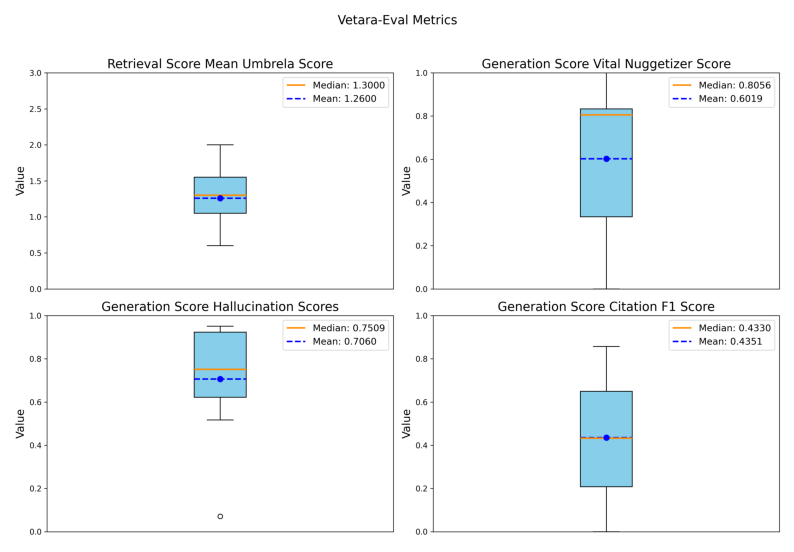

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 8))

img = mpimg.imread('metrics_summary.png')
plt.imshow(img)
plt.axis('off')
plt.show()